<a href="https://colab.research.google.com/github/manyana72/RL-Mario/blob/main/DoubleDQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

All required packages are installed.

In [ ]:
!pip install gym-super-mario-bros
!pip install ipython
!apt-get update
!apt-get install ffmpeg libsm6 libxext6  -y
!apt install -y libgl1-mesa-glx
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 199 kB 27.9 MB/s 
     |████████████████████████████████| 77 kB 5.5 MB/s 
  Created wheel for nes-py: filename=nes_py-8.2.1-cp37-cp37m-linux_x86_64.whl size=436926 sha256=9f1c6901e01da512ae5bea9ff47ba0502c35ef1d780c954dd6bd65474fd4f8e2
  Stored in directory: /root/.cache/pip/wheels/17/96/0e/22a8c7dbdf412d8e988286f223b223baf0f4ad90c9e699c56d
Successfully built nes-py
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:6 h

Required libraries are imported.

In [ ]:
import torch
import torch.nn as nn
import random
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from tqdm import tqdm
import pickle 
from gym_super_mario_bros.actions import RIGHT_ONLY
import gym
import numpy as np
import collections 
import cv2
import matplotlib.pyplot as plt
from IPython import display

All the same preprocessing as DeepQN is used here.

In [ ]:
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=5):
        """Return only every 5th frame"""
        """To analyse environment, we are considering the threshold of significant changes after every 5th frame"""
        super(MaxAndSkipEnv, self).__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, info

    def reset(self):
        """Clear past frame buffer and initialize agent to first obs"""
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs


class ProcessFrame84(gym.ObservationWrapper):
    """
    Downsamples image to 84x84
    Greyscales image
    Returns numpy array
    """
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

    def observation(self, obs):
        return ProcessFrame84.process(obs)

    @staticmethod
    def process(frame):
        if frame.size == 240 * 256 * 3:
            img = np.reshape(frame, [240, 256, 3]).astype(np.float32)
        else:
            assert False, "Unknown resolution."
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)


class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]),
                                                dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class ScaledFloatFrame(gym.ObservationWrapper):
    """Normalize pixel values in frame --> 0 to 1"""
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0


class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, axis=0),
                                                old_space.high.repeat(n_steps, axis=0), dtype=dtype)

    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset())

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer


def make_env(env):
    env = MaxAndSkipEnv(env)
    env = ProcessFrame84(env)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4)
    env = ScaledFloatFrame(env)
    return JoypadSpace(env, RIGHT_ONLY)

The DDQN Layers are defined here.
*   A CNN network using ReLu is used to process the image frames
*   The hyperparameters are standardized after performing many iterations.
*  The DDQN functions such as Remember (to store an experience), Recall( to randomly sample a batch of experiences), Experience_Replay (where the action of updating the q-values for each episode is carried out) 
*   The major difference here is that 2 separate Q value tables are used.

In [ ]:
class DQNSolver(nn.Module):

    def __init__(self, input_shape, n_actions):
        super(DQNSolver, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
    
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)
    
"""The DQN agent is described here"""
class DQNAgent:

    def __init__(self, state_space, action_space, max_memory_size, batch_size, gamma, lr,
                 dropout, exploration_max, exploration_min, exploration_decay, double_dq, pretrained):

        # Define DQN Layers
        self.state_space = state_space
        self.action_space = action_space
        self.double_dq = double_dq
        self.pretrained = pretrained
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        if self.double_dq:  
            self.local_net = DQNSolver(state_space, action_space).to(self.device)
            self.target_net = DQNSolver(state_space, action_space).to(self.device)
            
            if self.pretrained:
                self.local_net.load_state_dict(torch.load("dq1.pt", map_location=torch.device(self.device)))
                self.target_net.load_state_dict(torch.load("dq2.pt", map_location=torch.device(self.device)))
                    
            self.optimizer = torch.optim.Adam(self.local_net.parameters(), lr=lr)
            self.copy = 200  # Copy the local model weights into the target network every 200 steps
            self.step = 0
        else:  
            self.dqn = DQNSolver(state_space, action_space).to(self.device)
            
            if self.pretrained:
                self.dqn.load_state_dict(torch.load("dq.pt", map_location=torch.device(self.device)))
            self.optimizer = torch.optim.Adam(self.dqn.parameters(), lr=lr)

        # Create memory
        self.max_memory_size = max_memory_size
        if self.pretrained:
            self.STATE_MEM = torch.load("STATE_MEM.pt")
            self.ACTION_MEM = torch.load("ACTION_MEM.pt")
            self.REWARD_MEM = torch.load("REWARD_MEM.pt")
            self.STATE2_MEM = torch.load("STATE2_MEM.pt")
            self.DONE_MEM = torch.load("DONE_MEM.pt")
            with open("ending_position.pkl", 'rb') as f:
                self.ending_position = pickle.load(f)
            with open("num_in_queue.pkl", 'rb') as f:
                self.num_in_queue = pickle.load(f)
        else:
            self.STATE_MEM = torch.zeros(max_memory_size, *self.state_space)
            self.ACTION_MEM = torch.zeros(max_memory_size, 1)
            self.REWARD_MEM = torch.zeros(max_memory_size, 1)
            self.STATE2_MEM = torch.zeros(max_memory_size, *self.state_space)
            self.DONE_MEM = torch.zeros(max_memory_size, 1)
            self.ending_position = 0
            self.num_in_queue = 0
        
        self.memory_sample_size = batch_size
        
        # Learning parameters
        self.gamma = gamma
        self.l1 = nn.SmoothL1Loss().to(self.device) # Also known as Huber loss
        self.exploration_max = exploration_max
        self.exploration_rate = exploration_max
        self.exploration_min = exploration_min
        self.exploration_decay = exploration_decay

    def remember(self, state, action, reward, state2, done):
        self.STATE_MEM[self.ending_position] = state.float()
        self.ACTION_MEM[self.ending_position] = action.float()
        self.REWARD_MEM[self.ending_position] = reward.float()
        self.STATE2_MEM[self.ending_position] = state2.float()
        self.DONE_MEM[self.ending_position] = done.float()
        self.ending_position = (self.ending_position + 1) % self.max_memory_size  # FIFO tensor
        self.num_in_queue = min(self.num_in_queue + 1, self.max_memory_size)
        
    def recall(self):
        # Randomly sample 'batch size' experiences
        idx = random.choices(range(self.num_in_queue), k=self.memory_sample_size)
        
        STATE = self.STATE_MEM[idx]
        ACTION = self.ACTION_MEM[idx]
        REWARD = self.REWARD_MEM[idx]
        STATE2 = self.STATE2_MEM[idx]
        DONE = self.DONE_MEM[idx]
        
        return STATE, ACTION, REWARD, STATE2, DONE

    def act(self, state):
        # Epsilon-greedy action
        
        if self.double_dq:
            self.step += 1
        if random.random() < self.exploration_rate:  
            return torch.tensor([[random.randrange(self.action_space)]])
        if self.double_dq:
            # Local net is used for the policy
            return torch.argmax(self.local_net(state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()
        else:
            return torch.argmax(self.dqn(state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()

    def copy_model(self):
        # Copy local net weights into target net
        
        self.target_net.load_state_dict(self.local_net.state_dict())
    
    def experience_replay(self):
        
        if self.double_dq and self.step % self.copy == 0:
            self.copy_model()

        if self.memory_sample_size > self.num_in_queue:
            return

        STATE, ACTION, REWARD, STATE2, DONE = self.recall()
        STATE = STATE.to(self.device)
        ACTION = ACTION.to(self.device)
        REWARD = REWARD.to(self.device)
        STATE2 = STATE2.to(self.device)
        DONE = DONE.to(self.device)
        
        self.optimizer.zero_grad()
        if self.double_dq:
            # Double Q-Learning target is Q*(S, A) <- r + γ max_a Q_target(S', a)
            target = REWARD + torch.mul((self.gamma * 
                                        self.target_net(STATE2).max(1).values.unsqueeze(1)), 
                                        1 - DONE)

            current = self.local_net(STATE).gather(1, ACTION.long()) # Local net approximation of Q-value                
            current = self.dqn(STATE).gather(1, ACTION.long())
        
        loss = self.l1(current, target)
        loss.backward() # Compute gradients
        self.optimizer.step() # Backpropagate error

        self.exploration_rate *= self.exploration_decay
        
        # Makes sure that exploration rate is always at least 'exploration min'
        self.exploration_rate = max(self.exploration_rate, self.exploration_min)

In [ ]:
def vectorize_action(action, action_space):
    # Given a scalar action, return a one-hot encoded action
    
    return [0 for _ in range(action)] + [1] + [0 for _ in range(action + 1, action_space)]

In [ ]:
"""In order to project the output, while showing the final trained agent playing"""
def show_state(env, ep=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Episode: %d %s" % (ep, info))
    plt.axis('off')
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [ ]:
def run(training_mode, pretrained):
   
    env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
    env = make_env(env)  # Wraps the environment so that frames are grayscale 
    observation_space = env.observation_space.shape
    action_space = env.action_space.n

    """The parameters below are taken after performing many loops, and eventually finding the most optimal set, through trial and error."""

    agent = DQNAgent(state_space=observation_space,
                     action_space=action_space,
                     max_memory_size=30000,
                     batch_size=32,
                     gamma=0.90,
                     lr=0.00025,
                     dropout=0.,
                     exploration_max=1.0,
                     exploration_min=0.02,
                     exploration_decay=0.99,
                     double_dq=True,
                     pretrained=pretrained)
    
    num_episodes = 600
    env.reset()
    total_rewards = []
    
    for ep_num in tqdm(range(num_episodes)):
        state = env.reset()
        state = torch.Tensor([state])
        total_reward = 0
        steps = 0
        while True:
            if not training_mode:
                show_state(env, ep_num)
            action = agent.act(state)
            steps += 1
            
            state_next, reward, terminal, info = env.step(int(action[0]))
            total_reward += reward
            state_next = torch.Tensor([state_next])
            reward = torch.tensor([reward]).unsqueeze(0)
            
            terminal = torch.tensor([int(terminal)]).unsqueeze(0)
            
            if training_mode:
                agent.remember(state, action, reward, state_next, terminal)
                agent.experience_replay()
            
            state = state_next
            if terminal:
                break
        
        total_rewards.append(total_reward)

        print("Total reward after episode {} is {}".format(ep_num + 1, total_rewards[-1]))
        num_episodes += 1      
    
    if training_mode:
        with open("ending_position.pkl", "wb") as f:
            pickle.dump(agent.ending_position, f)
        with open("num_in_queue.pkl", "wb") as f:
            pickle.dump(agent.num_in_queue, f)
        with open("total_rewards.pkl", "wb") as f:
            pickle.dump(total_rewards, f)
        if agent.double_dq:
            torch.save(agent.local_net.state_dict(), "dq1.pt")
            torch.save(agent.target_net.state_dict(), "dq2.pt")
        else:
            torch.save(agent.dqn.state_dict(), "dq.pt")  
        torch.save(agent.STATE_MEM,  "STATE_MEM.pt")
        torch.save(agent.ACTION_MEM, "ACTION_MEM.pt")
        torch.save(agent.REWARD_MEM, "REWARD_MEM.pt")
        torch.save(agent.STATE2_MEM, "STATE2_MEM.pt")
        torch.save(agent.DONE_MEM,   "DONE_MEM.pt")
    
    env.close()
run(training_mode=True, pretrained=False)
#In order to view our agent play Super Mario, change the training_mode to False; pretrained to True

  0%|          | 1/600 [00:16<2:46:34, 16.68s/it]

Total reward after episode 1 is 633.0


  0%|          | 2/600 [00:25<2:02:49, 12.32s/it]

Total reward after episode 2 is 632.0


  0%|          | 3/600 [00:42<2:23:39, 14.44s/it]

Total reward after episode 3 is 757.0


  1%|          | 4/600 [00:46<1:40:34, 10.13s/it]

Total reward after episode 4 is 235.0


  1%|          | 5/600 [00:49<1:15:44,  7.64s/it]

Total reward after episode 5 is 250.0


  1%|          | 6/600 [01:19<2:29:34, 15.11s/it]

Total reward after episode 6 is 588.0


  1%|          | 7/600 [01:22<1:50:50, 11.22s/it]

Total reward after episode 7 is 250.0


  1%|▏         | 8/600 [01:25<1:25:38,  8.68s/it]

Total reward after episode 8 is 250.0


  2%|▏         | 9/600 [01:29<1:08:55,  7.00s/it]

Total reward after episode 9 is 250.0


  2%|▏         | 10/600 [01:32<59:31,  6.05s/it] 

Total reward after episode 10 is 238.0


  2%|▏         | 11/600 [01:36<51:26,  5.24s/it]

Total reward after episode 11 is 250.0


  2%|▏         | 12/600 [01:39<45:56,  4.69s/it]

Total reward after episode 12 is 249.0


  2%|▏         | 13/600 [01:43<43:17,  4.42s/it]

Total reward after episode 13 is 250.0


  2%|▏         | 14/600 [01:47<40:33,  4.15s/it]

Total reward after episode 14 is 248.0


  2%|▎         | 15/600 [01:51<40:11,  4.12s/it]

Total reward after episode 15 is 238.0


  3%|▎         | 16/600 [01:54<38:10,  3.92s/it]

Total reward after episode 16 is 250.0


  3%|▎         | 17/600 [01:58<36:44,  3.78s/it]

Total reward after episode 17 is 250.0


  3%|▎         | 18/600 [02:01<35:34,  3.67s/it]

Total reward after episode 18 is 250.0


  3%|▎         | 19/600 [02:04<34:49,  3.60s/it]

Total reward after episode 19 is 250.0


  3%|▎         | 20/600 [02:09<36:23,  3.76s/it]

Total reward after episode 20 is 250.0


  4%|▎         | 21/600 [02:12<35:27,  3.67s/it]

Total reward after episode 21 is 250.0


  4%|▎         | 22/600 [02:15<34:43,  3.60s/it]

Total reward after episode 22 is 250.0


  4%|▍         | 23/600 [03:03<2:42:46, 16.93s/it]

Total reward after episode 23 is 987.0


  4%|▍         | 24/600 [03:41<3:43:07, 23.24s/it]

Total reward after episode 24 is 1005.0


  4%|▍         | 25/600 [03:45<2:46:04, 17.33s/it]

Total reward after episode 25 is 251.0


  4%|▍         | 26/600 [03:48<2:05:50, 13.15s/it]

Total reward after episode 26 is 248.0


  4%|▍         | 27/600 [03:52<1:37:46, 10.24s/it]

Total reward after episode 27 is 248.0


  5%|▍         | 28/600 [04:09<1:57:20, 12.31s/it]

Total reward after episode 28 is 814.0


  5%|▍         | 29/600 [04:12<1:31:44,  9.64s/it]

Total reward after episode 29 is 250.0


  5%|▌         | 30/600 [04:16<1:14:17,  7.82s/it]

Total reward after episode 30 is 251.0


  5%|▌         | 31/600 [04:20<1:03:15,  6.67s/it]

Total reward after episode 31 is 236.0


  5%|▌         | 32/600 [04:25<59:39,  6.30s/it]  

Total reward after episode 32 is 248.0


  6%|▌         | 33/600 [04:29<51:48,  5.48s/it]

Total reward after episode 33 is 251.0


  6%|▌         | 34/600 [04:33<46:59,  4.98s/it]

Total reward after episode 34 is 244.0


  6%|▌         | 35/600 [04:36<43:20,  4.60s/it]

Total reward after episode 35 is 243.0


  6%|▌         | 36/600 [04:40<39:32,  4.21s/it]

Total reward after episode 36 is 250.0


  6%|▌         | 37/600 [04:43<36:26,  3.88s/it]

Total reward after episode 37 is 252.0


  6%|▋         | 38/600 [05:01<1:15:08,  8.02s/it]

Total reward after episode 38 is 636.0


  6%|▋         | 39/600 [05:20<1:47:00, 11.45s/it]

Total reward after episode 39 is 618.0


  7%|▋         | 40/600 [05:34<1:53:37, 12.17s/it]

Total reward after episode 40 is 617.0


  7%|▋         | 41/600 [05:37<1:28:23,  9.49s/it]

Total reward after episode 41 is 250.0


  7%|▋         | 42/600 [05:58<1:58:53, 12.78s/it]

Total reward after episode 42 is 728.0


  7%|▋         | 43/600 [06:01<1:32:01,  9.91s/it]

Total reward after episode 43 is 252.0


  7%|▋         | 44/600 [06:04<1:13:32,  7.94s/it]

Total reward after episode 44 is 247.0


  8%|▊         | 45/600 [06:08<1:02:49,  6.79s/it]

Total reward after episode 45 is 252.0


  8%|▊         | 46/600 [06:12<53:43,  5.82s/it]  

Total reward after episode 46 is 252.0


  8%|▊         | 47/600 [06:23<1:08:42,  7.46s/it]

Total reward after episode 47 is 630.0


  8%|▊         | 48/600 [06:32<1:13:16,  7.96s/it]

Total reward after episode 48 is 621.0


  8%|▊         | 49/600 [06:46<1:29:37,  9.76s/it]

Total reward after episode 49 is 646.0


  8%|▊         | 50/600 [06:54<1:24:30,  9.22s/it]

Total reward after episode 50 is 629.0


  8%|▊         | 51/600 [06:57<1:07:50,  7.41s/it]

Total reward after episode 51 is 246.0


  9%|▊         | 52/600 [07:01<56:26,  6.18s/it]  

Total reward after episode 52 is 248.0


  9%|▉         | 53/600 [07:04<48:08,  5.28s/it]

Total reward after episode 53 is 246.0


  9%|▉         | 54/600 [07:08<45:05,  4.95s/it]

Total reward after episode 54 is 243.0


  9%|▉         | 55/600 [07:11<40:08,  4.42s/it]

Total reward after episode 55 is 247.0


  9%|▉         | 56/600 [07:15<38:15,  4.22s/it]

Total reward after episode 56 is 251.0


 10%|▉         | 57/600 [07:35<1:22:23,  9.10s/it]

Total reward after episode 57 is 807.0


 10%|▉         | 58/600 [07:39<1:06:48,  7.40s/it]

Total reward after episode 58 is 248.0


 10%|▉         | 59/600 [07:42<55:29,  6.15s/it]  

Total reward after episode 59 is 247.0


 10%|█         | 60/600 [07:46<48:02,  5.34s/it]

Total reward after episode 60 is 249.0


 10%|█         | 61/600 [07:49<41:58,  4.67s/it]

Total reward after episode 61 is 252.0


 10%|█         | 62/600 [07:52<37:44,  4.21s/it]

Total reward after episode 62 is 250.0


 10%|█         | 63/600 [07:55<34:45,  3.88s/it]

Total reward after episode 63 is 252.0


 11%|█         | 64/600 [07:58<33:06,  3.71s/it]

Total reward after episode 64 is 243.0


 11%|█         | 65/600 [08:14<1:04:33,  7.24s/it]

Total reward after episode 65 is 618.0


 11%|█         | 66/600 [08:17<54:21,  6.11s/it]  

Total reward after episode 66 is 250.0


 11%|█         | 67/600 [08:20<46:23,  5.22s/it]

Total reward after episode 67 is 252.0


 11%|█▏        | 68/600 [08:23<40:51,  4.61s/it]

Total reward after episode 68 is 252.0


 12%|█▏        | 69/600 [08:27<37:44,  4.27s/it]

Total reward after episode 69 is 246.0


 12%|█▏        | 70/600 [08:30<35:37,  4.03s/it]

Total reward after episode 70 is 250.0


 12%|█▏        | 71/600 [08:34<33:12,  3.77s/it]

Total reward after episode 71 is 252.0


 12%|█▏        | 72/600 [08:37<31:34,  3.59s/it]

Total reward after episode 72 is 252.0


 12%|█▏        | 73/600 [08:42<35:55,  4.09s/it]

Total reward after episode 73 is 252.0


 12%|█▏        | 74/600 [08:59<1:09:35,  7.94s/it]

Total reward after episode 74 is 606.0


 12%|█▎        | 75/600 [09:16<1:33:55, 10.73s/it]

Total reward after episode 75 is 814.0


 13%|█▎        | 76/600 [09:19<1:13:52,  8.46s/it]

Total reward after episode 76 is 252.0


 13%|█▎        | 77/600 [09:30<1:20:37,  9.25s/it]

Total reward after episode 77 is 619.0


 13%|█▎        | 78/600 [09:42<1:26:02,  9.89s/it]

Total reward after episode 78 is 609.0


 13%|█▎        | 79/600 [09:45<1:08:18,  7.87s/it]

Total reward after episode 79 is 249.0


 13%|█▎        | 80/600 [10:08<1:46:48, 12.32s/it]

Total reward after episode 80 is 1030.0


 14%|█▎        | 81/600 [10:11<1:23:52,  9.70s/it]

Total reward after episode 81 is 237.0


 14%|█▎        | 82/600 [10:14<1:06:46,  7.73s/it]

Total reward after episode 82 is 249.0


 14%|█▍        | 83/600 [10:18<54:51,  6.37s/it]  

Total reward after episode 83 is 252.0


 14%|█▍        | 84/600 [10:21<46:28,  5.40s/it]

Total reward after episode 84 is 252.0


 14%|█▍        | 85/600 [10:24<40:39,  4.74s/it]

Total reward after episode 85 is 252.0


 14%|█▍        | 86/600 [10:27<36:32,  4.27s/it]

Total reward after episode 86 is 249.0


 14%|█▍        | 87/600 [10:31<34:23,  4.02s/it]

Total reward after episode 87 is 239.0


 15%|█▍        | 88/600 [10:42<53:30,  6.27s/it]

Total reward after episode 88 is 631.0


 15%|█▍        | 89/600 [10:45<45:29,  5.34s/it]

Total reward after episode 89 is 249.0


 15%|█▌        | 90/600 [11:28<2:20:20, 16.51s/it]

Total reward after episode 90 is 999.0


 15%|█▌        | 91/600 [11:46<2:25:03, 17.10s/it]

Total reward after episode 91 is 636.0


 15%|█▌        | 92/600 [11:49<1:49:21, 12.92s/it]

Total reward after episode 92 is 246.0


 16%|█▌        | 93/600 [11:53<1:24:23,  9.99s/it]

Total reward after episode 93 is 252.0


 16%|█▌        | 94/600 [12:02<1:21:46,  9.70s/it]

Total reward after episode 94 is 625.0


 16%|█▌        | 95/600 [12:06<1:07:16,  7.99s/it]

Total reward after episode 95 is 235.0


 16%|█▌        | 96/600 [12:09<56:46,  6.76s/it]  

Total reward after episode 96 is 233.0


 16%|█▌        | 97/600 [12:31<1:32:43, 11.06s/it]

Total reward after episode 97 is 1339.0


 16%|█▋        | 98/600 [12:34<1:13:28,  8.78s/it]

Total reward after episode 98 is 249.0


 16%|█▋        | 99/600 [12:37<59:16,  7.10s/it]  

Total reward after episode 99 is 252.0


 17%|█▋        | 100/600 [12:40<49:22,  5.92s/it]

Total reward after episode 100 is 252.0


 17%|█▋        | 101/600 [12:44<42:28,  5.11s/it]

Total reward after episode 101 is 248.0


 17%|█▋        | 102/600 [12:47<37:35,  4.53s/it]

Total reward after episode 102 is 250.0


 17%|█▋        | 103/600 [12:50<34:08,  4.12s/it]

Total reward after episode 103 is 251.0


 17%|█▋        | 104/600 [12:53<31:44,  3.84s/it]

Total reward after episode 104 is 252.0


 18%|█▊        | 105/600 [12:56<29:57,  3.63s/it]

Total reward after episode 105 is 252.0


 18%|█▊        | 106/600 [12:59<28:43,  3.49s/it]

Total reward after episode 106 is 252.0


 18%|█▊        | 107/600 [13:12<50:32,  6.15s/it]

Total reward after episode 107 is 631.0


 18%|█▊        | 108/600 [13:15<43:41,  5.33s/it]

Total reward after episode 108 is 249.0


 18%|█▊        | 109/600 [13:19<39:35,  4.84s/it]

Total reward after episode 109 is 239.0


 18%|█▊        | 110/600 [13:22<35:17,  4.32s/it]

Total reward after episode 110 is 249.0


 18%|█▊        | 111/600 [13:25<32:10,  3.95s/it]

Total reward after episode 111 is 252.0


 19%|█▊        | 112/600 [13:28<30:04,  3.70s/it]

Total reward after episode 112 is 252.0


 19%|█▉        | 113/600 [13:31<28:30,  3.51s/it]

Total reward after episode 113 is 252.0


 19%|█▉        | 114/600 [13:43<48:16,  5.96s/it]

Total reward after episode 114 is 622.0


 19%|█▉        | 115/600 [14:10<1:38:47, 12.22s/it]

Total reward after episode 115 is 1026.0


 19%|█▉        | 116/600 [14:29<1:55:59, 14.38s/it]

Total reward after episode 116 is 757.0


 20%|█▉        | 117/600 [14:32<1:28:38, 11.01s/it]

Total reward after episode 117 is 251.0


 20%|█▉        | 118/600 [14:51<1:46:41, 13.28s/it]

Total reward after episode 118 is 765.0


 20%|█▉        | 119/600 [15:06<1:51:01, 13.85s/it]

Total reward after episode 119 is 1047.0


 20%|██        | 120/600 [15:25<2:02:12, 15.28s/it]

Total reward after episode 120 is 1062.0


 20%|██        | 121/600 [15:42<2:07:06, 15.92s/it]

Total reward after episode 121 is 613.0


 20%|██        | 122/600 [16:08<2:31:18, 18.99s/it]

Total reward after episode 122 is 1026.0


 20%|██        | 123/600 [16:28<2:33:43, 19.34s/it]

Total reward after episode 123 is 808.0


 21%|██        | 124/600 [16:45<2:27:38, 18.61s/it]

Total reward after episode 124 is 769.0


 21%|██        | 125/600 [17:23<3:12:11, 24.28s/it]

Total reward after episode 125 is 701.0


 21%|██        | 126/600 [17:54<3:26:54, 26.19s/it]

Total reward after episode 126 is 724.0


 21%|██        | 127/600 [18:07<2:56:40, 22.41s/it]

Total reward after episode 127 is 630.0


 21%|██▏       | 128/600 [18:10<2:10:51, 16.63s/it]

Total reward after episode 128 is 252.0


 22%|██▏       | 129/600 [18:13<1:38:46, 12.58s/it]

Total reward after episode 129 is 252.0


 22%|██▏       | 130/600 [18:23<1:31:14, 11.65s/it]

Total reward after episode 130 is 639.0


 22%|██▏       | 131/600 [18:31<1:21:42, 10.45s/it]

Total reward after episode 131 is 609.0


 22%|██▏       | 132/600 [18:44<1:27:44, 11.25s/it]

Total reward after episode 132 is 625.0


 22%|██▏       | 133/600 [18:54<1:26:28, 11.11s/it]

Total reward after episode 133 is 629.0


 22%|██▏       | 134/600 [19:10<1:35:57, 12.35s/it]

Total reward after episode 134 is 1046.0


 22%|██▎       | 135/600 [19:18<1:26:39, 11.18s/it]

Total reward after episode 135 is 622.0


 23%|██▎       | 136/600 [19:40<1:50:11, 14.25s/it]

Total reward after episode 136 is 1036.0


 23%|██▎       | 137/600 [19:59<2:02:30, 15.88s/it]

Total reward after episode 137 is 1039.0


 23%|██▎       | 138/600 [20:09<1:49:06, 14.17s/it]

Total reward after episode 138 is 623.0


 23%|██▎       | 139/600 [20:34<2:12:15, 17.21s/it]

Total reward after episode 139 is 1029.0


 23%|██▎       | 140/600 [20:37<1:40:12, 13.07s/it]

Total reward after episode 140 is 247.0


 24%|██▎       | 141/600 [20:47<1:33:49, 12.26s/it]

Total reward after episode 141 is 618.0


 24%|██▎       | 142/600 [20:58<1:30:15, 11.82s/it]

Total reward after episode 142 is 649.0


 24%|██▍       | 143/600 [21:10<1:28:49, 11.66s/it]

Total reward after episode 143 is 623.0


 24%|██▍       | 144/600 [21:22<1:30:40, 11.93s/it]

Total reward after episode 144 is 611.0


 24%|██▍       | 145/600 [21:32<1:26:48, 11.45s/it]

Total reward after episode 145 is 638.0


 24%|██▍       | 146/600 [21:41<1:19:31, 10.51s/it]

Total reward after episode 146 is 623.0


 24%|██▍       | 147/600 [22:11<2:03:27, 16.35s/it]

Total reward after episode 147 is 721.0


 25%|██▍       | 148/600 [22:32<2:14:56, 17.91s/it]

Total reward after episode 148 is 1037.0


 25%|██▍       | 149/600 [23:09<2:55:58, 23.41s/it]

Total reward after episode 149 is 1008.0


 25%|██▌       | 150/600 [23:19<2:25:28, 19.40s/it]

Total reward after episode 150 is 650.0


 25%|██▌       | 151/600 [23:33<2:13:48, 17.88s/it]

Total reward after episode 151 is 1049.0


 25%|██▌       | 152/600 [23:57<2:27:50, 19.80s/it]

Total reward after episode 152 is 765.0


 26%|██▌       | 153/600 [24:01<1:51:17, 14.94s/it]

Total reward after episode 153 is 241.0


 26%|██▌       | 154/600 [24:08<1:34:49, 12.76s/it]

Total reward after episode 154 is 621.0


 26%|██▌       | 155/600 [24:28<1:49:04, 14.71s/it]

Total reward after episode 155 is 1039.0


 26%|██▌       | 156/600 [24:41<1:44:48, 14.16s/it]

Total reward after episode 156 is 1053.0


 26%|██▌       | 157/600 [24:53<1:40:53, 13.67s/it]

Total reward after episode 157 is 729.0


 26%|██▋       | 158/600 [25:09<1:45:19, 14.30s/it]

Total reward after episode 158 is 614.0


 26%|██▋       | 159/600 [25:24<1:47:23, 14.61s/it]

Total reward after episode 159 is 641.0


 27%|██▋       | 160/600 [25:33<1:33:22, 12.73s/it]

Total reward after episode 160 is 627.0


 27%|██▋       | 161/600 [25:51<1:45:48, 14.46s/it]

Total reward after episode 161 is 1041.0


 27%|██▋       | 162/600 [25:59<1:30:09, 12.35s/it]

Total reward after episode 162 is 626.0


 27%|██▋       | 163/600 [26:21<1:52:43, 15.48s/it]

Total reward after episode 163 is 1032.0


 27%|██▋       | 164/600 [26:39<1:58:16, 16.28s/it]

Total reward after episode 164 is 636.0


 28%|██▊       | 165/600 [26:47<1:39:07, 13.67s/it]

Total reward after episode 165 is 628.0


 28%|██▊       | 166/600 [26:50<1:16:44, 10.61s/it]

Total reward after episode 166 is 252.0


 28%|██▊       | 167/600 [27:49<3:01:13, 25.11s/it]

Total reward after episode 167 is 970.0


 28%|██▊       | 168/600 [28:08<2:46:49, 23.17s/it]

Total reward after episode 168 is 617.0


 28%|██▊       | 169/600 [28:11<2:03:51, 17.24s/it]

Total reward after episode 169 is 250.0


 28%|██▊       | 170/600 [28:19<1:42:46, 14.34s/it]

Total reward after episode 170 is 623.0


 28%|██▊       | 171/600 [28:22<1:18:35, 10.99s/it]

Total reward after episode 171 is 248.0


 29%|██▊       | 172/600 [28:25<1:01:36,  8.64s/it]

Total reward after episode 172 is 252.0


 29%|██▉       | 173/600 [28:43<1:21:19, 11.43s/it]

Total reward after episode 173 is 623.0


 29%|██▉       | 174/600 [28:57<1:26:12, 12.14s/it]

Total reward after episode 174 is 1049.0


 29%|██▉       | 175/600 [29:07<1:21:36, 11.52s/it]

Total reward after episode 175 is 634.0


 29%|██▉       | 176/600 [29:19<1:21:00, 11.46s/it]

Total reward after episode 176 is 623.0


 30%|██▉       | 177/600 [29:44<1:49:25, 15.52s/it]

Total reward after episode 177 is 1030.0


 30%|██▉       | 178/600 [29:47<1:23:18, 11.84s/it]

Total reward after episode 178 is 249.0


 30%|██▉       | 179/600 [30:02<1:30:49, 12.94s/it]

Total reward after episode 179 is 779.0


 30%|███       | 180/600 [30:17<1:34:13, 13.46s/it]

Total reward after episode 180 is 1046.0


 30%|███       | 181/600 [30:49<2:12:00, 18.90s/it]

Total reward after episode 181 is 1016.0


 30%|███       | 182/600 [31:06<2:07:47, 18.34s/it]

Total reward after episode 182 is 1044.0


 30%|███       | 183/600 [31:31<2:21:50, 20.41s/it]

Total reward after episode 183 is 1028.0


 31%|███       | 184/600 [31:34<1:45:43, 15.25s/it]

Total reward after episode 184 is 252.0


 31%|███       | 185/600 [31:38<1:21:02, 11.72s/it]

Total reward after episode 185 is 241.0


 31%|███       | 186/600 [31:41<1:03:42,  9.23s/it]

Total reward after episode 186 is 239.0


 31%|███       | 187/600 [31:44<51:38,  7.50s/it]  

Total reward after episode 187 is 249.0


 31%|███▏      | 188/600 [32:01<1:11:15, 10.38s/it]

Total reward after episode 188 is 597.0


 32%|███▏      | 189/600 [32:05<56:51,  8.30s/it]  

Total reward after episode 189 is 250.0


 32%|███▏      | 190/600 [32:08<46:29,  6.80s/it]

Total reward after episode 190 is 249.0


 32%|███▏      | 191/600 [32:12<40:10,  5.89s/it]

Total reward after episode 191 is 235.0


 32%|███▏      | 192/600 [32:15<35:08,  5.17s/it]

Total reward after episode 192 is 250.0


 32%|███▏      | 193/600 [32:29<51:47,  7.64s/it]

Total reward after episode 193 is 616.0


 32%|███▏      | 194/600 [32:33<44:06,  6.52s/it]

Total reward after episode 194 is 236.0


 32%|███▎      | 195/600 [32:54<1:13:27, 10.88s/it]

Total reward after episode 195 is 1036.0


 33%|███▎      | 196/600 [33:27<1:58:02, 17.53s/it]

Total reward after episode 196 is 785.0


 33%|███▎      | 197/600 [33:31<1:30:13, 13.43s/it]

Total reward after episode 197 is 249.0


 33%|███▎      | 198/600 [33:48<1:38:17, 14.67s/it]

Total reward after episode 198 is 813.0


 33%|███▎      | 199/600 [34:00<1:32:52, 13.90s/it]

Total reward after episode 199 is 607.0


 33%|███▎      | 200/600 [34:27<1:58:09, 17.72s/it]

Total reward after episode 200 is 798.0


 34%|███▎      | 201/600 [34:30<1:29:14, 13.42s/it]

Total reward after episode 201 is 249.0


 34%|███▎      | 202/600 [34:39<1:18:29, 11.83s/it]

Total reward after episode 202 is 630.0


 34%|███▍      | 203/600 [34:46<1:09:16, 10.47s/it]

Total reward after episode 203 is 616.0


 34%|███▍      | 204/600 [34:49<55:01,  8.34s/it]  

Total reward after episode 204 is 249.0


 34%|███▍      | 205/600 [35:06<1:12:10, 10.96s/it]

Total reward after episode 205 is 624.0


 34%|███▍      | 206/600 [35:10<56:58,  8.68s/it]  

Total reward after episode 206 is 249.0


 34%|███▍      | 207/600 [35:13<47:07,  7.20s/it]

Total reward after episode 207 is 238.0


 35%|███▍      | 208/600 [35:17<39:09,  5.99s/it]

Total reward after episode 208 is 250.0


 35%|███▍      | 209/600 [35:20<33:49,  5.19s/it]

Total reward after episode 209 is 249.0


 35%|███▌      | 210/600 [35:23<29:50,  4.59s/it]

Total reward after episode 210 is 250.0


 35%|███▌      | 211/600 [35:27<28:24,  4.38s/it]

Total reward after episode 211 is 237.0


 35%|███▌      | 212/600 [35:43<50:08,  7.75s/it]

Total reward after episode 212 is 641.0


 36%|███▌      | 213/600 [35:50<50:08,  7.77s/it]

Total reward after episode 213 is 606.0


 36%|███▌      | 214/600 [36:03<1:00:08,  9.35s/it]

Total reward after episode 214 is 626.0


 36%|███▌      | 215/600 [36:24<1:22:16, 12.82s/it]

Total reward after episode 215 is 807.0


 36%|███▌      | 216/600 [36:28<1:04:48, 10.13s/it]

Total reward after episode 216 is 237.0


 36%|███▌      | 217/600 [36:32<52:18,  8.19s/it]  

Total reward after episode 217 is 249.0


 36%|███▋      | 218/600 [36:53<1:17:23, 12.16s/it]

Total reward after episode 218 is 807.0


 36%|███▋      | 219/600 [36:57<1:00:52,  9.59s/it]

Total reward after episode 219 is 247.0


 37%|███▋      | 220/600 [37:00<48:59,  7.74s/it]  

Total reward after episode 220 is 249.0


 37%|███▋      | 221/600 [37:08<49:32,  7.84s/it]

Total reward after episode 221 is 627.0


 37%|███▋      | 222/600 [37:12<41:07,  6.53s/it]

Total reward after episode 222 is 249.0


 37%|███▋      | 223/600 [37:15<34:53,  5.55s/it]

Total reward after episode 223 is 250.0


 37%|███▋      | 224/600 [37:19<30:54,  4.93s/it]

Total reward after episode 224 is 250.0


 38%|███▊      | 225/600 [37:34<49:40,  7.95s/it]

Total reward after episode 225 is 642.0


 38%|███▊      | 226/600 [37:46<58:30,  9.39s/it]

Total reward after episode 226 is 728.0


 38%|███▊      | 227/600 [38:02<1:09:58, 11.26s/it]

Total reward after episode 227 is 817.0


 38%|███▊      | 228/600 [38:26<1:33:35, 15.10s/it]

Total reward after episode 228 is 612.0


 38%|███▊      | 229/600 [38:29<1:11:26, 11.55s/it]

Total reward after episode 229 is 249.0


 38%|███▊      | 230/600 [38:33<56:51,  9.22s/it]  

Total reward after episode 230 is 236.0


 38%|███▊      | 231/600 [38:41<55:03,  8.95s/it]

Total reward after episode 231 is 636.0


 39%|███▊      | 232/600 [38:58<1:08:00, 11.09s/it]

Total reward after episode 232 is 816.0


 39%|███▉      | 233/600 [39:08<1:07:05, 10.97s/it]

Total reward after episode 233 is 608.0


 39%|███▉      | 234/600 [39:29<1:25:12, 13.97s/it]

Total reward after episode 234 is 808.0


 39%|███▉      | 235/600 [39:33<1:05:43, 10.81s/it]

Total reward after episode 235 is 249.0


 39%|███▉      | 236/600 [39:36<52:46,  8.70s/it]  

Total reward after episode 236 is 239.0


 40%|███▉      | 237/600 [40:01<1:21:33, 13.48s/it]

Total reward after episode 237 is 583.0


 40%|███▉      | 238/600 [40:20<1:31:17, 15.13s/it]

Total reward after episode 238 is 811.0


 40%|███▉      | 239/600 [40:24<1:10:06, 11.65s/it]

Total reward after episode 239 is 239.0


 40%|████      | 240/600 [40:27<55:16,  9.21s/it]  

Total reward after episode 240 is 241.0


 40%|████      | 241/600 [40:47<1:14:21, 12.43s/it]

Total reward after episode 241 is 809.0


 40%|████      | 242/600 [41:14<1:39:46, 16.72s/it]

Total reward after episode 242 is 1314.0


 40%|████      | 243/600 [41:17<1:15:54, 12.76s/it]

Total reward after episode 243 is 239.0


 41%|████      | 244/600 [41:21<59:44, 10.07s/it]  

Total reward after episode 244 is 240.0


 41%|████      | 245/600 [41:28<53:34,  9.06s/it]

Total reward after episode 245 is 609.0


 41%|████      | 246/600 [41:43<1:04:53, 11.00s/it]

Total reward after episode 246 is 621.0


 41%|████      | 247/600 [41:47<51:27,  8.75s/it]  

Total reward after episode 247 is 250.0


 41%|████▏     | 248/600 [42:39<2:08:40, 21.93s/it]

Total reward after episode 248 is 1375.0


 42%|████▏     | 249/600 [42:43<1:35:27, 16.32s/it]

Total reward after episode 249 is 246.0


 42%|████▏     | 250/600 [42:46<1:12:57, 12.51s/it]

Total reward after episode 250 is 243.0


 42%|████▏     | 251/600 [42:50<58:02,  9.98s/it]  

Total reward after episode 251 is 239.0


 42%|████▏     | 252/600 [43:15<1:23:25, 14.38s/it]

Total reward after episode 252 is 1335.0


 42%|████▏     | 253/600 [43:22<1:10:51, 12.25s/it]

Total reward after episode 253 is 609.0


 42%|████▏     | 254/600 [43:42<1:23:59, 14.56s/it]

Total reward after episode 254 is 1317.0


 42%|████▎     | 255/600 [43:50<1:12:44, 12.65s/it]

Total reward after episode 255 is 654.0


 43%|████▎     | 256/600 [44:02<1:11:29, 12.47s/it]

Total reward after episode 256 is 619.0


 43%|████▎     | 257/600 [44:22<1:22:54, 14.50s/it]

Total reward after episode 257 is 810.0


 43%|████▎     | 258/600 [44:25<1:03:37, 11.16s/it]

Total reward after episode 258 is 249.0


 43%|████▎     | 259/600 [44:29<51:26,  9.05s/it]  

Total reward after episode 259 is 235.0


 43%|████▎     | 260/600 [44:33<41:55,  7.40s/it]

Total reward after episode 260 is 248.0


 44%|████▎     | 261/600 [44:53<1:03:45, 11.28s/it]

Total reward after episode 261 is 1343.0


 44%|████▎     | 262/600 [45:11<1:14:40, 13.26s/it]

Total reward after episode 262 is 813.0


 44%|████▍     | 263/600 [45:43<1:45:28, 18.78s/it]

Total reward after episode 263 is 709.0


 44%|████▍     | 264/600 [45:53<1:31:27, 16.33s/it]

Total reward after episode 264 is 620.0


 44%|████▍     | 265/600 [46:15<1:41:04, 18.10s/it]

Total reward after episode 265 is 1577.0


 44%|████▍     | 266/600 [46:19<1:16:13, 13.69s/it]

Total reward after episode 266 is 248.0


 44%|████▍     | 267/600 [46:57<1:56:32, 21.00s/it]

Total reward after episode 267 is 1311.0


 45%|████▍     | 268/600 [47:07<1:37:57, 17.70s/it]

Total reward after episode 268 is 617.0


 45%|████▍     | 269/600 [47:24<1:36:22, 17.47s/it]

Total reward after episode 269 is 1348.0


 45%|████▌     | 270/600 [47:40<1:33:39, 17.03s/it]

Total reward after episode 270 is 747.0


 45%|████▌     | 271/600 [47:47<1:16:22, 13.93s/it]

Total reward after episode 271 is 610.0


 45%|████▌     | 272/600 [47:50<59:32, 10.89s/it]  

Total reward after episode 272 is 240.0


 46%|████▌     | 273/600 [48:06<1:07:05, 12.31s/it]

Total reward after episode 273 is 641.0


 46%|████▌     | 274/600 [48:10<52:45,  9.71s/it]  

Total reward after episode 274 is 236.0


 46%|████▌     | 275/600 [48:13<42:29,  7.85s/it]

Total reward after episode 275 is 242.0


 46%|████▌     | 276/600 [48:28<53:47,  9.96s/it]

Total reward after episode 276 is 818.0


 46%|████▌     | 277/600 [48:31<42:44,  7.94s/it]

Total reward after episode 277 is 250.0


 46%|████▋     | 278/600 [48:47<54:28, 10.15s/it]

Total reward after episode 278 is 1348.0


 46%|████▋     | 279/600 [48:50<43:35,  8.15s/it]

Total reward after episode 279 is 244.0


 47%|████▋     | 280/600 [48:54<36:27,  6.83s/it]

Total reward after episode 280 is 243.0


 47%|████▋     | 281/600 [49:03<40:00,  7.53s/it]

Total reward after episode 281 is 619.0


 47%|████▋     | 282/600 [49:07<33:43,  6.36s/it]

Total reward after episode 282 is 240.0


 47%|████▋     | 283/600 [49:14<35:36,  6.74s/it]

Total reward after episode 283 is 612.0


 47%|████▋     | 284/600 [49:31<51:26,  9.77s/it]

Total reward after episode 284 is 815.0


 48%|████▊     | 285/600 [49:35<41:26,  7.90s/it]

Total reward after episode 285 is 240.0


 48%|████▊     | 286/600 [49:38<34:16,  6.55s/it]

Total reward after episode 286 is 247.0


 48%|████▊     | 287/600 [50:06<1:08:31, 13.13s/it]

Total reward after episode 287 is 795.0


 48%|████▊     | 288/600 [50:14<59:42, 11.48s/it]  

Total reward after episode 288 is 609.0


 48%|████▊     | 289/600 [50:18<47:08,  9.10s/it]

Total reward after episode 289 is 252.0


 48%|████▊     | 290/600 [50:23<40:33,  7.85s/it]

Total reward after episode 290 is 229.0


 48%|████▊     | 291/600 [50:26<33:56,  6.59s/it]

Total reward after episode 291 is 242.0


 49%|████▊     | 292/600 [50:29<28:36,  5.57s/it]

Total reward after episode 292 is 250.0


 49%|████▉     | 293/600 [50:33<25:33,  5.00s/it]

Total reward after episode 293 is 241.0


 49%|████▉     | 294/600 [51:15<1:22:09, 16.11s/it]

Total reward after episode 294 is 730.0


 49%|████▉     | 295/600 [51:18<1:02:09, 12.23s/it]

Total reward after episode 295 is 250.0


 49%|████▉     | 296/600 [51:22<49:31,  9.77s/it]  

Total reward after episode 296 is 237.0


 50%|████▉     | 297/600 [51:36<55:57, 11.08s/it]

Total reward after episode 297 is 819.0


 50%|████▉     | 298/600 [51:40<44:31,  8.85s/it]

Total reward after episode 298 is 241.0


 50%|████▉     | 299/600 [52:01<1:03:07, 12.58s/it]

Total reward after episode 299 is 1428.0


 50%|█████     | 300/600 [52:09<55:07, 11.02s/it]  

Total reward after episode 300 is 613.0


 50%|█████     | 301/600 [52:12<43:12,  8.67s/it]

Total reward after episode 301 is 248.0


 50%|█████     | 302/600 [52:30<56:43, 11.42s/it]

Total reward after episode 302 is 1062.0


 50%|█████     | 303/600 [52:56<1:18:19, 15.82s/it]

Total reward after episode 303 is 799.0


 51%|█████     | 304/600 [53:11<1:16:17, 15.46s/it]

Total reward after episode 304 is 819.0


 51%|█████     | 305/600 [53:14<57:59, 11.80s/it]  

Total reward after episode 305 is 250.0


 51%|█████     | 306/600 [53:17<45:10,  9.22s/it]

Total reward after episode 306 is 251.0


 51%|█████     | 307/600 [53:26<45:09,  9.25s/it]

Total reward after episode 307 is 651.0


 51%|█████▏    | 308/600 [53:29<36:08,  7.43s/it]

Total reward after episode 308 is 250.0


 52%|█████▏    | 309/600 [53:52<57:18, 11.82s/it]

Total reward after episode 309 is 806.0


 52%|█████▏    | 310/600 [53:55<45:06,  9.33s/it]

Total reward after episode 310 is 243.0


 52%|█████▏    | 311/600 [54:13<56:55, 11.82s/it]

Total reward after episode 311 is 1438.0


 52%|█████▏    | 312/600 [54:16<44:19,  9.24s/it]

Total reward after episode 312 is 250.0


 52%|█████▏    | 313/600 [54:23<41:48,  8.74s/it]

Total reward after episode 313 is 622.0


 52%|█████▏    | 314/600 [54:38<49:56, 10.48s/it]

Total reward after episode 314 is 819.0


 52%|█████▎    | 315/600 [54:55<59:29, 12.52s/it]

Total reward after episode 315 is 747.0


 53%|█████▎    | 316/600 [54:59<46:31,  9.83s/it]

Total reward after episode 316 is 250.0


 53%|█████▎    | 317/600 [55:02<37:11,  7.89s/it]

Total reward after episode 317 is 247.0


 53%|█████▎    | 318/600 [55:06<31:10,  6.63s/it]

Total reward after episode 318 is 243.0


 53%|█████▎    | 319/600 [55:26<50:32, 10.79s/it]

Total reward after episode 319 is 1580.0


 53%|█████▎    | 320/600 [55:31<41:07,  8.81s/it]

Total reward after episode 320 is 226.0


 54%|█████▎    | 321/600 [55:34<33:57,  7.30s/it]

Total reward after episode 321 is 236.0


 54%|█████▎    | 322/600 [55:43<35:06,  7.58s/it]

Total reward after episode 322 is 653.0


 54%|█████▍    | 323/600 [55:51<35:26,  7.68s/it]

Total reward after episode 323 is 654.0


 54%|█████▍    | 324/600 [55:54<29:09,  6.34s/it]

Total reward after episode 324 is 250.0


 54%|█████▍    | 325/600 [55:57<24:40,  5.38s/it]

Total reward after episode 325 is 250.0


 54%|█████▍    | 326/600 [56:01<22:41,  4.97s/it]

Total reward after episode 326 is 238.0


 55%|█████▍    | 327/600 [56:09<27:22,  6.02s/it]

Total reward after episode 327 is 622.0


 55%|█████▍    | 328/600 [56:13<23:59,  5.29s/it]

Total reward after episode 328 is 236.0


 55%|█████▍    | 329/600 [56:16<21:04,  4.67s/it]

Total reward after episode 329 is 247.0


 55%|█████▌    | 330/600 [56:27<28:46,  6.39s/it]

Total reward after episode 330 is 622.0


 55%|█████▌    | 331/600 [56:30<25:08,  5.61s/it]

Total reward after episode 331 is 238.0


 55%|█████▌    | 332/600 [56:49<42:00,  9.41s/it]

Total reward after episode 332 is 636.0


 56%|█████▌    | 333/600 [56:57<40:28,  9.10s/it]

Total reward after episode 333 is 639.0


 56%|█████▌    | 334/600 [57:04<37:12,  8.39s/it]

Total reward after episode 334 is 608.0


 56%|█████▌    | 335/600 [57:25<54:43, 12.39s/it]

Total reward after episode 335 is 750.0


 56%|█████▌    | 336/600 [57:32<47:00, 10.68s/it]

Total reward after episode 336 is 610.0


 56%|█████▌    | 337/600 [57:52<58:53, 13.43s/it]

Total reward after episode 337 is 1433.0


 56%|█████▋    | 338/600 [57:55<45:27, 10.41s/it]

Total reward after episode 338 is 247.0


 56%|█████▋    | 339/600 [57:59<35:52,  8.25s/it]

Total reward after episode 339 is 248.0


 57%|█████▋    | 340/600 [58:22<55:16, 12.75s/it]

Total reward after episode 340 is 627.0


 57%|█████▋    | 341/600 [58:31<50:59, 11.81s/it]

Total reward after episode 341 is 610.0


 57%|█████▋    | 342/600 [58:35<39:42,  9.24s/it]

Total reward after episode 342 is 250.0


 57%|█████▋    | 343/600 [58:38<32:24,  7.57s/it]

Total reward after episode 343 is 241.0


 57%|█████▋    | 344/600 [58:42<26:44,  6.27s/it]

Total reward after episode 344 is 248.0


 57%|█████▊    | 345/600 [58:49<28:17,  6.66s/it]

Total reward after episode 345 is 623.0


 58%|█████▊    | 346/600 [58:52<23:49,  5.63s/it]

Total reward after episode 346 is 250.0


 58%|█████▊    | 347/600 [59:09<37:59,  9.01s/it]

Total reward after episode 347 is 1440.0


 58%|█████▊    | 348/600 [59:13<30:33,  7.28s/it]

Total reward after episode 348 is 246.0


 58%|█████▊    | 349/600 [59:35<49:46, 11.90s/it]

Total reward after episode 349 is 1430.0


 58%|█████▊    | 350/600 [59:38<38:44,  9.30s/it]

Total reward after episode 350 is 247.0


 58%|█████▊    | 351/600 [59:58<51:19, 12.37s/it]

Total reward after episode 351 is 767.0


 59%|█████▊    | 352/600 [1:00:05<44:16, 10.71s/it]

Total reward after episode 352 is 611.0


 59%|█████▉    | 353/600 [1:00:08<34:50,  8.46s/it]

Total reward after episode 353 is 250.0


 59%|█████▉    | 354/600 [1:00:11<28:16,  6.90s/it]

Total reward after episode 354 is 248.0


 59%|█████▉    | 355/600 [1:00:15<24:01,  5.88s/it]

Total reward after episode 355 is 239.0


 59%|█████▉    | 356/600 [1:00:31<35:57,  8.84s/it]

Total reward after episode 356 is 1067.0


 60%|█████▉    | 357/600 [1:00:34<28:57,  7.15s/it]

Total reward after episode 357 is 248.0


 60%|█████▉    | 358/600 [1:00:50<39:56,  9.90s/it]

Total reward after episode 358 is 640.0


 60%|█████▉    | 359/600 [1:01:14<57:16, 14.26s/it]

Total reward after episode 359 is 726.0


 60%|██████    | 360/600 [1:01:25<52:26, 13.11s/it]

Total reward after episode 360 is 626.0


 60%|██████    | 361/600 [1:01:52<1:08:54, 17.30s/it]

Total reward after episode 361 is 1033.0


 60%|██████    | 362/600 [1:02:03<1:01:26, 15.49s/it]

Total reward after episode 362 is 615.0


 60%|██████    | 363/600 [1:02:12<52:57, 13.41s/it]  

Total reward after episode 363 is 629.0


 61%|██████    | 364/600 [1:02:15<40:52, 10.39s/it]

Total reward after episode 364 is 247.0


 61%|██████    | 365/600 [1:02:18<32:16,  8.24s/it]

Total reward after episode 365 is 252.0


 61%|██████    | 366/600 [1:02:22<26:46,  6.87s/it]

Total reward after episode 366 is 240.0


 61%|██████    | 367/600 [1:02:38<36:40,  9.45s/it]

Total reward after episode 367 is 620.0


 61%|██████▏   | 368/600 [1:02:50<39:36, 10.24s/it]

Total reward after episode 368 is 609.0


 62%|██████▏   | 369/600 [1:03:11<52:20, 13.60s/it]

Total reward after episode 369 is 1433.0


 62%|██████▏   | 370/600 [1:03:15<40:50, 10.65s/it]

Total reward after episode 370 is 240.0


 62%|██████▏   | 371/600 [1:03:24<39:17, 10.29s/it]

Total reward after episode 371 is 635.0


 62%|██████▏   | 372/600 [1:03:33<37:24,  9.84s/it]

Total reward after episode 372 is 631.0


 62%|██████▏   | 373/600 [1:03:41<34:35,  9.15s/it]

Total reward after episode 373 is 609.0


 62%|██████▏   | 374/600 [1:04:10<57:20, 15.22s/it]

Total reward after episode 374 is 1321.0


 62%|██████▎   | 375/600 [1:04:22<54:00, 14.40s/it]

Total reward after episode 375 is 745.0


 63%|██████▎   | 376/600 [1:04:31<46:45, 12.52s/it]

Total reward after episode 376 is 633.0


 63%|██████▎   | 377/600 [1:04:39<41:45, 11.24s/it]

Total reward after episode 377 is 637.0


 63%|██████▎   | 378/600 [1:04:42<32:39,  8.83s/it]

Total reward after episode 378 is 250.0


 63%|██████▎   | 379/600 [1:04:59<41:47, 11.34s/it]

Total reward after episode 379 is 606.0


 63%|██████▎   | 380/600 [1:05:07<37:40, 10.27s/it]

Total reward after episode 380 is 609.0


 64%|██████▎   | 381/600 [1:05:37<59:33, 16.32s/it]

Total reward after episode 381 is 791.0


 64%|██████▎   | 382/600 [1:05:48<53:22, 14.69s/it]

Total reward after episode 382 is 617.0


 64%|██████▍   | 383/600 [1:06:16<1:06:42, 18.44s/it]

Total reward after episode 383 is 1413.0


 64%|██████▍   | 384/600 [1:06:40<1:12:20, 20.10s/it]

Total reward after episode 384 is 1337.0


 64%|██████▍   | 385/600 [1:06:50<1:01:08, 17.06s/it]

Total reward after episode 385 is 606.0


 64%|██████▍   | 386/600 [1:07:13<1:08:07, 19.10s/it]

Total reward after episode 386 is 1415.0


 64%|██████▍   | 387/600 [1:07:22<56:08, 15.82s/it]  

Total reward after episode 387 is 615.0


 65%|██████▍   | 388/600 [1:08:02<1:22:11, 23.26s/it]

Total reward after episode 388 is 1398.0


 65%|██████▍   | 389/600 [1:08:34<1:30:30, 25.74s/it]

Total reward after episode 389 is 1408.0


 65%|██████▌   | 390/600 [1:08:52<1:22:34, 23.59s/it]

Total reward after episode 390 is 723.0


 65%|██████▌   | 391/600 [1:08:55<1:00:54, 17.48s/it]

Total reward after episode 391 is 248.0


 65%|██████▌   | 392/600 [1:09:04<51:12, 14.77s/it]  

Total reward after episode 392 is 639.0


 66%|██████▌   | 393/600 [1:09:12<44:26, 12.88s/it]

Total reward after episode 393 is 609.0


 66%|██████▌   | 394/600 [1:09:21<39:24, 11.48s/it]

Total reward after episode 394 is 640.0


 66%|██████▌   | 395/600 [1:09:24<30:40,  8.98s/it]

Total reward after episode 395 is 247.0


 66%|██████▌   | 396/600 [1:09:32<30:06,  8.85s/it]

Total reward after episode 396 is 653.0


 66%|██████▌   | 397/600 [1:09:49<38:07, 11.27s/it]

Total reward after episode 397 is 1330.0


 66%|██████▋   | 398/600 [1:10:05<42:58, 12.77s/it]

Total reward after episode 398 is 815.0


 66%|██████▋   | 399/600 [1:10:10<34:16, 10.23s/it]

Total reward after episode 399 is 242.0


 67%|██████▋   | 400/600 [1:10:30<43:49, 13.15s/it]

Total reward after episode 400 is 606.0


 67%|██████▋   | 401/600 [1:10:56<56:58, 17.18s/it]

Total reward after episode 401 is 726.0


 67%|██████▋   | 402/600 [1:11:05<48:11, 14.60s/it]

Total reward after episode 402 is 632.0


 67%|██████▋   | 403/600 [1:11:12<40:36, 12.37s/it]

Total reward after episode 403 is 617.0


 67%|██████▋   | 404/600 [1:11:20<35:45, 10.95s/it]

Total reward after episode 404 is 608.0


 68%|██████▊   | 405/600 [1:11:36<41:16, 12.70s/it]

Total reward after episode 405 is 745.0


 68%|██████▊   | 406/600 [1:11:54<45:47, 14.16s/it]

Total reward after episode 406 is 612.0


 68%|██████▊   | 407/600 [1:12:11<47:46, 14.85s/it]

Total reward after episode 407 is 617.0


 68%|██████▊   | 408/600 [1:12:17<39:37, 12.38s/it]

Total reward after episode 408 is 610.0


 68%|██████▊   | 409/600 [1:12:32<41:57, 13.18s/it]

Total reward after episode 409 is 817.0


 68%|██████▊   | 410/600 [1:12:57<52:51, 16.69s/it]

Total reward after episode 410 is 1426.0


 68%|██████▊   | 411/600 [1:13:05<44:25, 14.10s/it]

Total reward after episode 411 is 621.0


 69%|██████▊   | 412/600 [1:13:26<50:13, 16.03s/it]

Total reward after episode 412 is 1063.0


 69%|██████▉   | 413/600 [1:13:44<52:29, 16.84s/it]

Total reward after episode 413 is 1438.0


 69%|██████▉   | 414/600 [1:14:17<1:06:29, 21.45s/it]

Total reward after episode 414 is 1409.0


 69%|██████▉   | 415/600 [1:14:33<1:01:02, 19.80s/it]

Total reward after episode 415 is 640.0


 69%|██████▉   | 416/600 [1:14:41<50:27, 16.45s/it]  

Total reward after episode 416 is 624.0


 70%|██████▉   | 417/600 [1:14:51<43:51, 14.38s/it]

Total reward after episode 417 is 611.0


 70%|██████▉   | 418/600 [1:14:54<33:25, 11.02s/it]

Total reward after episode 418 is 252.0


 70%|██████▉   | 419/600 [1:15:46<1:10:18, 23.31s/it]

Total reward after episode 419 is 982.0


 70%|███████   | 420/600 [1:15:55<57:03, 19.02s/it]  

Total reward after episode 420 is 630.0


 70%|███████   | 421/600 [1:16:11<54:08, 18.15s/it]

Total reward after episode 421 is 640.0


 70%|███████   | 422/600 [1:16:21<46:48, 15.78s/it]

Total reward after episode 422 is 650.0


 70%|███████   | 423/600 [1:16:38<47:40, 16.16s/it]

Total reward after episode 423 is 1440.0


 71%|███████   | 424/600 [1:16:59<51:22, 17.51s/it]

Total reward after episode 424 is 808.0


 71%|███████   | 425/600 [1:17:16<50:25, 17.29s/it]

Total reward after episode 425 is 1052.0


 71%|███████   | 426/600 [1:17:24<41:53, 14.44s/it]

Total reward after episode 426 is 617.0


 71%|███████   | 427/600 [1:17:44<46:56, 16.28s/it]

Total reward after episode 427 is 1429.0


 71%|███████▏  | 428/600 [1:18:04<49:33, 17.29s/it]

Total reward after episode 428 is 1344.0


 72%|███████▏  | 429/600 [1:18:40<1:05:36, 23.02s/it]

Total reward after episode 429 is 1403.0


 72%|███████▏  | 430/600 [1:18:56<59:15, 20.92s/it]  

Total reward after episode 430 is 640.0


 72%|███████▏  | 431/600 [1:18:59<43:57, 15.61s/it]

Total reward after episode 431 is 248.0


 72%|███████▏  | 432/600 [1:19:17<44:57, 16.06s/it]

Total reward after episode 432 is 1436.0


 72%|███████▏  | 433/600 [1:19:24<37:49, 13.59s/it]

Total reward after episode 433 is 613.0


 72%|███████▏  | 434/600 [1:19:41<40:33, 14.66s/it]

Total reward after episode 434 is 1051.0


 72%|███████▎  | 435/600 [1:19:58<41:45, 15.18s/it]

Total reward after episode 435 is 1340.0


 73%|███████▎  | 436/600 [1:20:07<36:11, 13.24s/it]

Total reward after episode 436 is 615.0


 73%|███████▎  | 437/600 [1:20:22<37:34, 13.83s/it]

Total reward after episode 437 is 818.0


 73%|███████▎  | 438/600 [1:20:30<33:09, 12.28s/it]

Total reward after episode 438 is 617.0


 73%|███████▎  | 439/600 [1:20:58<45:37, 17.00s/it]

Total reward after episode 439 is 796.0


 73%|███████▎  | 440/600 [1:21:14<44:21, 16.64s/it]

Total reward after episode 440 is 775.0


 74%|███████▎  | 441/600 [1:21:32<44:49, 16.91s/it]

Total reward after episode 441 is 1438.0


 74%|███████▎  | 442/600 [1:22:03<56:06, 21.30s/it]

Total reward after episode 442 is 1558.0


 74%|███████▍  | 443/600 [1:22:13<46:25, 17.74s/it]

Total reward after episode 443 is 623.0


 74%|███████▍  | 444/600 [1:22:23<40:13, 15.47s/it]

Total reward after episode 444 is 614.0


 74%|███████▍  | 445/600 [1:22:31<34:12, 13.24s/it]

Total reward after episode 445 is 617.0


 74%|███████▍  | 446/600 [1:22:39<30:02, 11.71s/it]

Total reward after episode 446 is 620.0


 74%|███████▍  | 447/600 [1:22:48<27:43, 10.87s/it]

Total reward after episode 447 is 652.0


 75%|███████▍  | 448/600 [1:23:05<31:56, 12.61s/it]

Total reward after episode 448 is 1344.0


 75%|███████▍  | 449/600 [1:23:08<24:41,  9.81s/it]

Total reward after episode 449 is 248.0


 75%|███████▌  | 450/600 [1:23:29<32:56, 13.18s/it]

Total reward after episode 450 is 738.0


 75%|███████▌  | 451/600 [1:23:40<31:01, 12.49s/it]

Total reward after episode 451 is 637.0


 75%|███████▌  | 452/600 [1:23:43<23:57,  9.71s/it]

Total reward after episode 452 is 252.0


 76%|███████▌  | 453/600 [1:23:59<28:19, 11.56s/it]

Total reward after episode 453 is 1349.0


 76%|███████▌  | 454/600 [1:24:08<25:55, 10.66s/it]

Total reward after episode 454 is 617.0


 76%|███████▌  | 455/600 [1:24:17<24:57, 10.33s/it]

Total reward after episode 455 is 651.0


 76%|███████▌  | 456/600 [1:24:27<24:15, 10.11s/it]

Total reward after episode 456 is 613.0


 76%|███████▌  | 457/600 [1:24:56<37:41, 15.81s/it]

Total reward after episode 457 is 1022.0


 76%|███████▋  | 458/600 [1:25:06<33:21, 14.10s/it]

Total reward after episode 458 is 634.0


 76%|███████▋  | 459/600 [1:25:09<25:30, 10.85s/it]

Total reward after episode 459 is 248.0


 77%|███████▋  | 460/600 [1:25:19<24:50, 10.65s/it]

Total reward after episode 460 is 622.0


 77%|███████▋  | 461/600 [1:25:46<35:48, 15.46s/it]

Total reward after episode 461 is 1324.0


 77%|███████▋  | 462/600 [1:26:07<39:12, 17.05s/it]

Total reward after episode 462 is 1324.0


 77%|███████▋  | 463/600 [1:26:39<49:10, 21.53s/it]

Total reward after episode 463 is 1555.0


 77%|███████▋  | 464/600 [1:27:00<48:15, 21.29s/it]

Total reward after episode 464 is 809.0


 78%|███████▊  | 465/600 [1:27:34<56:53, 25.28s/it]

Total reward after episode 465 is 1316.0


 78%|███████▊  | 466/600 [1:27:44<46:06, 20.64s/it]

Total reward after episode 466 is 624.0


 78%|███████▊  | 467/600 [1:28:01<43:37, 19.68s/it]

Total reward after episode 467 is 1322.0


 78%|███████▊  | 468/600 [1:28:29<48:42, 22.14s/it]

Total reward after episode 468 is 1914.0


 78%|███████▊  | 469/600 [1:28:48<45:51, 21.01s/it]

Total reward after episode 469 is 1342.0


 78%|███████▊  | 470/600 [1:29:00<39:54, 18.42s/it]

Total reward after episode 470 is 646.0


 78%|███████▊  | 471/600 [1:29:18<39:16, 18.27s/it]

Total reward after episode 471 is 784.0


 79%|███████▊  | 472/600 [1:29:35<37:59, 17.81s/it]

Total reward after episode 472 is 598.0


 79%|███████▉  | 473/600 [1:29:50<36:03, 17.04s/it]

Total reward after episode 473 is 754.0


 79%|███████▉  | 474/600 [1:30:13<39:18, 18.72s/it]

Total reward after episode 474 is 1572.0


 79%|███████▉  | 475/600 [1:30:22<33:03, 15.87s/it]

Total reward after episode 475 is 625.0


 79%|███████▉  | 476/600 [1:30:39<33:50, 16.37s/it]

Total reward after episode 476 is 1323.0


 80%|███████▉  | 477/600 [1:31:00<36:16, 17.69s/it]

Total reward after episode 477 is 1584.0


 80%|███████▉  | 478/600 [1:31:18<35:56, 17.67s/it]

Total reward after episode 478 is 1322.0


 80%|███████▉  | 479/600 [1:31:46<41:57, 20.81s/it]

Total reward after episode 479 is 1328.0


 80%|████████  | 480/600 [1:32:22<50:54, 25.45s/it]

Total reward after episode 480 is 1012.0


 80%|████████  | 481/600 [1:32:30<40:15, 20.30s/it]

Total reward after episode 481 is 613.0


 80%|████████  | 482/600 [1:32:50<39:27, 20.07s/it]

Total reward after episode 482 is 1569.0


 80%|████████  | 483/600 [1:33:01<34:00, 17.44s/it]

Total reward after episode 483 is 607.0


 81%|████████  | 484/600 [1:33:36<43:47, 22.65s/it]

Total reward after episode 484 is 565.0


 81%|████████  | 485/600 [1:33:59<43:28, 22.68s/it]

Total reward after episode 485 is 776.0


 81%|████████  | 486/600 [1:34:30<47:56, 25.24s/it]

Total reward after episode 486 is 569.0


 81%|████████  | 487/600 [1:34:52<45:52, 24.36s/it]

Total reward after episode 487 is 1035.0


 81%|████████▏ | 488/600 [1:35:22<48:32, 26.01s/it]

Total reward after episode 488 is 1412.0


 82%|████████▏ | 489/600 [1:36:01<55:06, 29.78s/it]

Total reward after episode 489 is 1031.0


 82%|████████▏ | 490/600 [1:36:29<53:28, 29.17s/it]

Total reward after episode 490 is 1565.0


 82%|████████▏ | 491/600 [1:36:53<50:29, 27.79s/it]

Total reward after episode 491 is 1421.0


 82%|████████▏ | 492/600 [1:37:09<43:46, 24.32s/it]

Total reward after episode 492 is 612.0


 82%|████████▏ | 493/600 [1:37:25<38:52, 21.80s/it]

Total reward after episode 493 is 1071.0


 82%|████████▏ | 494/600 [1:37:51<40:45, 23.08s/it]

Total reward after episode 494 is 1030.0


 82%|████████▎ | 495/600 [1:38:14<40:18, 23.04s/it]

Total reward after episode 495 is 1688.0


 83%|████████▎ | 496/600 [1:38:36<39:10, 22.60s/it]

Total reward after episode 496 is 1043.0


 83%|████████▎ | 497/600 [1:38:51<35:07, 20.46s/it]

Total reward after episode 497 is 600.0


 83%|████████▎ | 498/600 [1:39:17<37:28, 22.04s/it]

Total reward after episode 498 is 1036.0


 83%|████████▎ | 499/600 [1:39:53<44:19, 26.33s/it]

Total reward after episode 499 is 1424.0


 83%|████████▎ | 500/600 [1:40:11<39:27, 23.67s/it]

Total reward after episode 500 is 774.0


 84%|████████▎ | 501/600 [1:40:14<28:56, 17.54s/it]

Total reward after episode 501 is 246.0


 84%|████████▎ | 502/600 [1:40:53<39:13, 24.02s/it]

Total reward after episode 502 is 1825.0


 84%|████████▍ | 503/600 [1:41:02<31:25, 19.43s/it]

Total reward after episode 503 is 609.0


 84%|████████▍ | 504/600 [1:41:05<23:20, 14.59s/it]

Total reward after episode 504 is 252.0


 84%|████████▍ | 505/600 [1:41:32<28:55, 18.27s/it]

Total reward after episode 505 is 1028.0


 84%|████████▍ | 506/600 [1:41:44<25:49, 16.48s/it]

Total reward after episode 506 is 625.0


 84%|████████▍ | 507/600 [1:42:14<31:32, 20.35s/it]

Total reward after episode 507 is 1545.0


 85%|████████▍ | 508/600 [1:42:32<30:12, 19.70s/it]

Total reward after episode 508 is 743.0


 85%|████████▍ | 509/600 [1:42:50<28:58, 19.11s/it]

Total reward after episode 509 is 618.0


 85%|████████▌ | 510/600 [1:43:24<35:33, 23.71s/it]

Total reward after episode 510 is 1686.0


 85%|████████▌ | 511/600 [1:43:27<26:04, 17.58s/it]

Total reward after episode 511 is 252.0


 85%|████████▌ | 512/600 [1:43:36<21:49, 14.89s/it]

Total reward after episode 512 is 608.0


 86%|████████▌ | 513/600 [1:43:39<16:32, 11.41s/it]

Total reward after episode 513 is 252.0


 86%|████████▌ | 514/600 [1:43:43<12:51,  8.97s/it]

Total reward after episode 514 is 252.0


 86%|████████▌ | 515/600 [1:44:04<18:04, 12.76s/it]

Total reward after episode 515 is 759.0


 86%|████████▌ | 516/600 [1:44:08<13:54,  9.94s/it]

Total reward after episode 516 is 252.0


 86%|████████▌ | 517/600 [1:44:18<14:07, 10.21s/it]

Total reward after episode 517 is 626.0


 86%|████████▋ | 518/600 [1:44:22<11:08,  8.15s/it]

Total reward after episode 518 is 246.0


 86%|████████▋ | 519/600 [1:44:39<14:48, 10.96s/it]

Total reward after episode 519 is 1051.0


 87%|████████▋ | 520/600 [1:44:48<13:53, 10.42s/it]

Total reward after episode 520 is 634.0


 87%|████████▋ | 521/600 [1:45:13<19:08, 14.54s/it]

Total reward after episode 521 is 1861.0


 87%|████████▋ | 522/600 [1:45:27<18:44, 14.41s/it]

Total reward after episode 522 is 602.0


 87%|████████▋ | 523/600 [1:45:44<19:41, 15.35s/it]

Total reward after episode 523 is 815.0


 87%|████████▋ | 524/600 [1:45:48<14:52, 11.74s/it]

Total reward after episode 524 is 252.0


 88%|████████▊ | 525/600 [1:46:07<17:38, 14.11s/it]

Total reward after episode 525 is 1578.0


 88%|████████▊ | 526/600 [1:46:10<13:23, 10.86s/it]

Total reward after episode 526 is 249.0


 88%|████████▊ | 527/600 [1:46:30<16:18, 13.40s/it]

Total reward after episode 527 is 760.0


 88%|████████▊ | 528/600 [1:47:00<21:58, 18.31s/it]

Total reward after episode 528 is 1852.0


 88%|████████▊ | 529/600 [1:47:08<18:05, 15.29s/it]

Total reward after episode 529 is 610.0


 88%|████████▊ | 530/600 [1:47:22<17:21, 14.88s/it]

Total reward after episode 530 is 1057.0


 88%|████████▊ | 531/600 [1:47:38<17:40, 15.37s/it]

Total reward after episode 531 is 1045.0


 89%|████████▊ | 532/600 [1:47:42<13:18, 11.75s/it]

Total reward after episode 532 is 249.0


 89%|████████▉ | 533/600 [1:48:01<15:45, 14.12s/it]

Total reward after episode 533 is 1048.0


 89%|████████▉ | 534/600 [1:48:04<11:57, 10.87s/it]

Total reward after episode 534 is 248.0


 89%|████████▉ | 535/600 [1:48:08<09:18,  8.60s/it]

Total reward after episode 535 is 252.0


 89%|████████▉ | 536/600 [1:48:11<07:29,  7.02s/it]

Total reward after episode 536 is 246.0


 90%|████████▉ | 537/600 [1:48:48<16:38, 15.85s/it]

Total reward after episode 537 is 1549.0


 90%|████████▉ | 538/600 [1:49:06<17:17, 16.74s/it]

Total reward after episode 538 is 773.0


 90%|████████▉ | 539/600 [1:49:16<14:43, 14.48s/it]

Total reward after episode 539 is 635.0


 90%|█████████ | 540/600 [1:49:24<12:34, 12.57s/it]

Total reward after episode 540 is 609.0


 90%|█████████ | 541/600 [1:49:27<09:37,  9.79s/it]

Total reward after episode 541 is 252.0


 90%|█████████ | 542/600 [1:49:35<09:00,  9.33s/it]

Total reward after episode 542 is 609.0


 90%|█████████ | 543/600 [1:49:58<12:44, 13.42s/it]

Total reward after episode 543 is 1846.0


 91%|█████████ | 544/600 [1:50:14<13:12, 14.15s/it]

Total reward after episode 544 is 641.0


 91%|█████████ | 545/600 [1:50:26<12:26, 13.58s/it]

Total reward after episode 545 is 743.0


 91%|█████████ | 546/600 [1:50:47<14:01, 15.58s/it]

Total reward after episode 546 is 767.0


 91%|█████████ | 547/600 [1:50:50<10:30, 11.90s/it]

Total reward after episode 547 is 252.0


 91%|█████████▏| 548/600 [1:50:53<08:05,  9.34s/it]

Total reward after episode 548 is 246.0


 92%|█████████▏| 549/600 [1:50:57<06:24,  7.54s/it]

Total reward after episode 549 is 252.0


 92%|█████████▏| 550/600 [1:51:00<05:13,  6.27s/it]

Total reward after episode 550 is 252.0


 92%|█████████▏| 551/600 [1:51:23<09:19, 11.42s/it]

Total reward after episode 551 is 1852.0


 92%|█████████▏| 552/600 [1:51:27<07:15,  9.08s/it]

Total reward after episode 552 is 252.0


 92%|█████████▏| 553/600 [1:51:30<05:45,  7.35s/it]

Total reward after episode 553 is 248.0


 92%|█████████▏| 554/600 [1:51:38<05:44,  7.49s/it]

Total reward after episode 554 is 614.0


 92%|█████████▎| 555/600 [1:51:48<06:09,  8.22s/it]

Total reward after episode 555 is 632.0


 93%|█████████▎| 556/600 [1:52:13<09:47, 13.36s/it]

Total reward after episode 556 is 1691.0


 93%|█████████▎| 557/600 [1:52:44<13:17, 18.54s/it]

Total reward after episode 557 is 1688.0


 93%|█████████▎| 558/600 [1:52:55<11:21, 16.24s/it]

Total reward after episode 558 is 623.0


 93%|█████████▎| 559/600 [1:52:58<08:27, 12.37s/it]

Total reward after episode 559 is 252.0


 93%|█████████▎| 560/600 [1:53:27<11:27, 17.19s/it]

Total reward after episode 560 is 1329.0


 94%|█████████▎| 561/600 [1:53:52<12:49, 19.73s/it]

Total reward after episode 561 is 587.0


 94%|█████████▎| 562/600 [1:54:07<11:28, 18.11s/it]

Total reward after episode 562 is 1057.0


 94%|█████████▍| 563/600 [1:54:10<08:27, 13.71s/it]

Total reward after episode 563 is 252.0


 94%|█████████▍| 564/600 [1:54:14<06:24, 10.68s/it]

Total reward after episode 564 is 248.0


 94%|█████████▍| 565/600 [1:54:17<04:57,  8.49s/it]

Total reward after episode 565 is 252.0


 94%|█████████▍| 566/600 [1:54:20<03:56,  6.96s/it]

Total reward after episode 566 is 246.0


 94%|█████████▍| 567/600 [1:54:35<05:06,  9.30s/it]

Total reward after episode 567 is 820.0


 95%|█████████▍| 568/600 [1:54:39<04:03,  7.60s/it]

Total reward after episode 568 is 252.0


 95%|█████████▍| 569/600 [1:54:42<03:16,  6.33s/it]

Total reward after episode 569 is 249.0


 95%|█████████▌| 570/600 [1:54:46<02:43,  5.44s/it]

Total reward after episode 570 is 247.0


 95%|█████████▌| 571/600 [1:54:49<02:19,  4.81s/it]

Total reward after episode 571 is 252.0


 95%|█████████▌| 572/600 [1:55:09<04:20,  9.31s/it]

Total reward after episode 572 is 1587.0


 96%|█████████▌| 573/600 [1:55:12<03:22,  7.52s/it]

Total reward after episode 573 is 248.0


 96%|█████████▌| 574/600 [1:55:31<04:48, 11.08s/it]

Total reward after episode 574 is 1585.0


 96%|█████████▌| 575/600 [1:55:48<05:20, 12.81s/it]

Total reward after episode 575 is 598.0


 96%|█████████▌| 576/600 [1:55:58<04:44, 11.84s/it]

Total reward after episode 576 is 652.0


 96%|█████████▌| 577/600 [1:56:01<03:33,  9.29s/it]

Total reward after episode 577 is 247.0


 96%|█████████▋| 578/600 [1:56:05<02:46,  7.55s/it]

Total reward after episode 578 is 248.0


 96%|█████████▋| 579/600 [1:56:26<04:02, 11.57s/it]

Total reward after episode 579 is 1577.0


 97%|█████████▋| 580/600 [1:56:57<05:47, 17.38s/it]

Total reward after episode 580 is 1684.0


 97%|█████████▋| 581/600 [1:57:14<05:32, 17.48s/it]

Total reward after episode 581 is 770.0


 97%|█████████▋| 582/600 [1:57:33<05:20, 17.82s/it]

Total reward after episode 582 is 1348.0


 97%|█████████▋| 583/600 [1:57:37<03:50, 13.56s/it]

Total reward after episode 583 is 245.0


 97%|█████████▋| 584/600 [1:57:40<02:47, 10.49s/it]

Total reward after episode 584 is 252.0


 98%|█████████▊| 585/600 [1:57:43<02:05,  8.34s/it]

Total reward after episode 585 is 252.0


 98%|█████████▊| 586/600 [1:57:47<01:36,  6.89s/it]

Total reward after episode 586 is 250.0


 98%|█████████▊| 587/600 [1:57:50<01:15,  5.83s/it]

Total reward after episode 587 is 252.0


 98%|█████████▊| 588/600 [1:57:53<01:01,  5.10s/it]

Total reward after episode 588 is 252.0


 98%|█████████▊| 589/600 [1:58:04<01:13,  6.65s/it]

Total reward after episode 589 is 627.0


 98%|█████████▊| 590/600 [1:58:07<00:56,  5.67s/it]

Total reward after episode 590 is 252.0


 98%|█████████▊| 591/600 [1:58:18<01:04,  7.18s/it]

Total reward after episode 591 is 637.0


 99%|█████████▊| 592/600 [1:58:37<01:25, 10.68s/it]

Total reward after episode 592 is 1048.0


 99%|█████████▉| 593/600 [1:58:40<00:59,  8.48s/it]

Total reward after episode 593 is 252.0


 99%|█████████▉| 594/600 [1:58:43<00:41,  6.95s/it]

Total reward after episode 594 is 252.0


 99%|█████████▉| 595/600 [1:58:47<00:29,  5.86s/it]

Total reward after episode 595 is 252.0


 99%|█████████▉| 596/600 [1:59:04<00:37,  9.33s/it]

Total reward after episode 596 is 1330.0


100%|█████████▉| 597/600 [1:59:07<00:22,  7.54s/it]

Total reward after episode 597 is 248.0


100%|█████████▉| 598/600 [1:59:11<00:12,  6.33s/it]

Total reward after episode 598 is 248.0


100%|█████████▉| 599/600 [1:59:19<00:06,  6.89s/it]

Total reward after episode 599 is 611.0


100%|██████████| 600/600 [1:59:23<00:00, 11.94s/it]

Total reward after episode 600 is 248.0


The output is not as expected due to lack of more training iterations

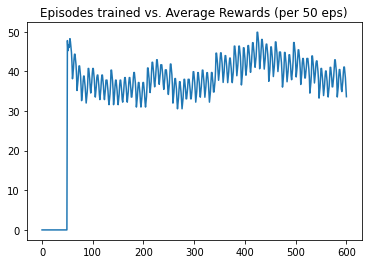

In [ ]:
with open("total_rewards.pkl", "rb") as f:
    data = np.array(list(f.read(600)))
    plt.title("Episodes trained vs. Average Rewards (per 50 eps)")
    plt.plot([0 for _ in range(50)] + 
        np.convolve(data, np.ones((50,))/50, mode="valid").tolist())
    plt.show()